In [1]:
import torch
import torch.nn as nn
from Nail_dataset import get_dataset
from torch.utils.data import DataLoader
from Model import get_model
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
 
    def forward(self, input, target):
        N = target.size(0)
        smooth = 1
 
        input_flat = input.view(N, -1)
        target_flat = target.view(N, -1)
 
        intersection = input_flat * target_flat
 
        loss = 2 * (intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth)
        loss = 1 - loss.sum() / N
 
        return loss


In [4]:

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y, image) in enumerate(dataloader):
        X = X.float()
        y = y.float()
        X, y = X.to(device), y.to(device)
        
        X = X.requires_grad_()
        # Compute prediction error
        pred = model(X)
        pred = F.sigmoid(pred)
#         loss = loss_fn(pred, y)
#         print(pred.shape)
#         print(y.shape)

        pred = torch.reshape(pred, (1,256,256))
        
        pred_flat = pred.view(-1)

        y_flat = y.view(-1)
            
            
        loss = loss_fn(pred_flat, y_flat)
#         print(loss)
        total_loss+=abs(loss)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 25 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"total_loss: {total_loss:>7f}  [{current:>5d}/{size:>5d}]")
    return total_loss

In [5]:
dataset = get_dataset()

train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

model = get_model()

# loss_fn = DiceLoss()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [6]:
image, mask, origin_image = next(iter(train_dataloader))

In [7]:
epochs = 200
device = 'cuda' if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(device)
min_loss=10000000000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    total_loss = train(train_dataloader, model, loss_fn, optimizer)
    if(total_loss < min_loss ):
        min_loss = total_loss
        print("#########save_best_model###########")
        torch.save(model.state_dict(), "best_model.pth")
print("Done!")

cuda
Epoch 1
-------------------------------


C:\Users\HMILAB\anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


total_loss: 0.922375  [    0/   41]
total_loss: 202.016068  [   25/   41]
#########save_best_model###########
Epoch 2
-------------------------------
total_loss: 15.194016  [    0/   41]
total_loss: 630.406372  [   25/   41]
Epoch 3
-------------------------------
total_loss: 18.385315  [    0/   41]
total_loss: 1235.429443  [   25/   41]
Epoch 4
-------------------------------
total_loss: 63.273834  [    0/   41]
total_loss: 2542.918945  [   25/   41]
Epoch 5
-------------------------------
total_loss: 159.533051  [    0/   41]
total_loss: 3990.751221  [   25/   41]
Epoch 6
-------------------------------
total_loss: 219.237457  [    0/   41]
total_loss: 5231.655762  [   25/   41]
Epoch 7
-------------------------------
total_loss: 226.342667  [    0/   41]
total_loss: 5491.230469  [   25/   41]
Epoch 8
-------------------------------
total_loss: 158.571793  [    0/   41]
total_loss: 5614.688965  [   25/   41]
Epoch 9
-------------------------------
total_loss: 196.544098  [    0/   4

KeyboardInterrupt: 

In [ ]:
ls D:\Project\Tony\anemia\code\keras_version

In [ ]:
torch.save(model.state_dict(), "D:/Project/Tony/anemia/code/keras_version/best_model_equalizehist.pth")

torch.Size([1, 1, 256, 256])


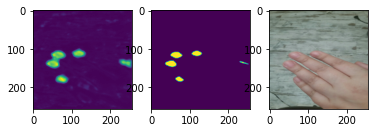

In [33]:
# model.load_state_dict(torch.load("best_model.pth"))
image, mask, origin_image = next(iter(train_dataloader))
image = image.float()
image = image.to(device)
prediction = model(image)
prediction = prediction.detach().cpu().numpy()
# for i in range(0, prediction.shape[2]):
#     for j in range(0, prediction.shape[3]):
#         if(prediction[0][0][i][j]<1.3):
#             prediction[0][0][i][j] = 0
#         else:
#             prediction[0][0][i][j] = 1
print(image.shape)
plt.subplot(1,3,1)
plt.imshow(prediction[0][0])
plt.subplot(1,3,2)
plt.imshow(mask[0])
plt.subplot(1,3,3)
plt.imshow(origin_image[0].cpu())

In [ ]:
p

In [ ]:
plt.imshow(prediction[0][0])
plt.show()

In [ ]:
plt.imshow(mask[0])
plt.show()